In [4]:
# add path to sispeuede to sys.path in python and turn off warnings
import os, os.path
import pathlib
import sys
import warnings
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import utils.common_data_needs as cdn

warnings.filterwarnings("ignore")

##  I'M LAZY, SO I HAVEN'T INSTALLED 

path_git = pathlib.Path("/Users/usuario/git")     # pathlib.Path("/Users/fabianfuentes/git")
for subdir in [
    #"sisepuede", 
    "sisepuede_data_pipeline",
    #"sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))
        

#path_sisepuede_inputs_database = pathlib.Path("/Users/fabianfuentes/git/sisepuede_inputs.sqlite")              # e.g., "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite"
path_sisepuede_inputs_database = pathlib.Path("/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite")

import lib.sisepuede_data_constructs as dc             # from sisepuede_data_pipeline

construct = dc.SISEPUEDEDataConstructs(path_output_database = path_sisepuede_inputs_database, )


In [21]:
# pull some SISEPUEDE elements
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )



In [5]:
dir_cur = pathlib.Path(os.getcwd())
input_data = dir_cur.joinpath("input_data")
output_data = dir_cur.joinpath("output_data")

In [6]:
gdp = construct.read_from_output_database(
    "GDP",
    table_type = "historical",
    
)

gdp.head()

,iso_alpha_3,year,gdp_mmm_usd
0,ABW,1986,1.320771
1,ABW,1987,1.533138
2,ABW,1988,1.818915
3,ABW,1989,2.038912
4,ABW,1990,2.120000


In [7]:
#filter data for Uganda
gdp = gdp[gdp['iso_alpha_3'] == 'UGA']
gdp.describe()

,year,gdp_mmm_usd
count,44.000000,44.000000
mean,2000.500000,42.300549
std,12.845233,30.475254
min,1979.000000,11.098871
25%,1989.750000,15.618110
50%,2000.500000,30.595000
75%,2011.250000,67.097500
max,2022.000000,107.730000


In [8]:
gdp = gdp[gdp['year'] <= 2022].copy() # Filter out future years
gdp.tail()

,iso_alpha_3,year,gdp_mmm_usd
7392,UGA,2018,90.79
7393,UGA,2019,96.64
7394,UGA,2020,99.49
7395,UGA,2021,103.01
7396,UGA,2022,107.73


In [9]:
# Growth rates Uganda Vision 2023-2050
growth_rates = [
    
 # Uganda Vision 2040 growth rates
    (2023, 2025, 8.35),   # 2023–2025: 8.35% 
    (2026, 2030, 8.22),   # 2026–2030: 8.22% 
    (2031, 2035, 8.07),   # 2031–2035: 8.07% 
    (2036, 2040, 7.83),   # 2036–2040: 7.83% 

 # Setting growth rates for the years 2041-2100
    (2041, 2050, 3.9),   # 2041–2050: 3.9%
    (2051, 2060, 2.0),   # 2051–2060: 2%
    (2061, 2070, 2.0),   # 2061–2070: 2%
    (2071, 2080, 2.0),   # 2071–2080: 2%
    (2081, 2090, 2.0),   # 2081–2090: 2%
    (2091, 2100, 2.0)    # 2091–2100: 2%
]



In [10]:
last_year = gdp['year'].max()
print(f"Last year in the dataset: {last_year}")

last_gdp = gdp.loc[gdp['year'] == last_year, 'gdp_mmm_usd'].values[0]
print(f"Last GDP value in the dataset: {last_gdp}")

Last year in the dataset: 2022
Last GDP value in the dataset: 107.73


<Axes: xlabel='year'>

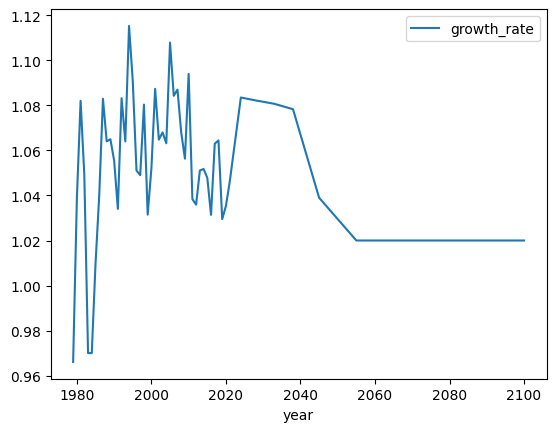

In [93]:
modvar_gdp = matt.get_variable("GDP", )

# some fields
_FIELD_GDP = modvar_gdp.fields[0]
_FIELD_GR = "growth_rate"

# build a dataframe
yrs = []
rates = []
for el in growth_rates:
    yr = int((el[0] + el[1])/2)
    yrs.append(yr)
    rates.append(1 + el[2]/100)

# 
df_rates = pd.DataFrame(
    {
        time_periods.field_year: yrs,
        _FIELD_GR: rates,
    }
)


##  build the gdp

df_gdp_rates_hist = (
    gdp
    .copy()
    .drop(columns = regions.field_iso, )
)
v = df_gdp_rates_hist[time_periods.field_year]


# 
df_gdp_rates_hist = (
    pd.merge(
        pd.DataFrame(
            {
                time_periods.field_year: range(v.min(), v.max() + 1, )
            }
        ),
        df_gdp_rates_hist,
        how = "left",
    )
    .interpolate()
    .sort_values(by = time_periods.field_year, )
    .reset_index(drop = True, )
)

# get growth rates before merging and interpolating 
vec_rates = df_gdp_rates_hist[_FIELD_GDP].to_numpy()[1:]/df_gdp_rates_hist[_FIELD_GDP].to_numpy()[0:-1]
df_gdp_rates_hist = (
    df_gdp_rates_hist
    .iloc[0:-1]
    .drop(columns = _FIELD_GDP, )
)
df_gdp_rates_hist[_FIELD_GR] = vec_rates


##  GET SPACE OF ALL YEARS, THEN MERGE OBSERVED POINTS AND INTERPOLATE BETWEEN

# get universe of years
df_space_years = cdn.spawn_years_space_df((df_gdp_rates_hist[time_periods.field_year].min(), 2101))

df_rates_proj = (
    pd.merge(
        df_space_years,
        pd.concat(
            [
                df_gdp_rates_hist,
                df_rates,
            ],
            axis = 0,
        ),
        how = "left",
    )
    .interpolate(method = "slinear")#, order = 2,)
    .ffill()
)
df_rates_proj.plot(x = "year")

##  Now, we use the cumulative product of interpolated growth rates applied to initial GDP to estimate GDP

In [113]:
# get cumulative growth rates
gdp_cumulative = np.concat(
    [
        np.ones(1),
        np.cumprod(df_rates_proj[_FIELD_GR]).to_numpy()
    ]
)

gdp_0 = gdp[
    gdp[time_periods.field_year] == gdp[time_periods.field_year].min()
][_FIELD_GDP].iloc[0]

# set the gdp out
df_gdp = pd.DataFrame(
    {
        time_periods.field_year: df_space_years[time_periods.field_year],
        _FIELD_GDP: gdp_0*gdp_cumulative[0:-1],
    }
)

<Axes: xlabel='year'>

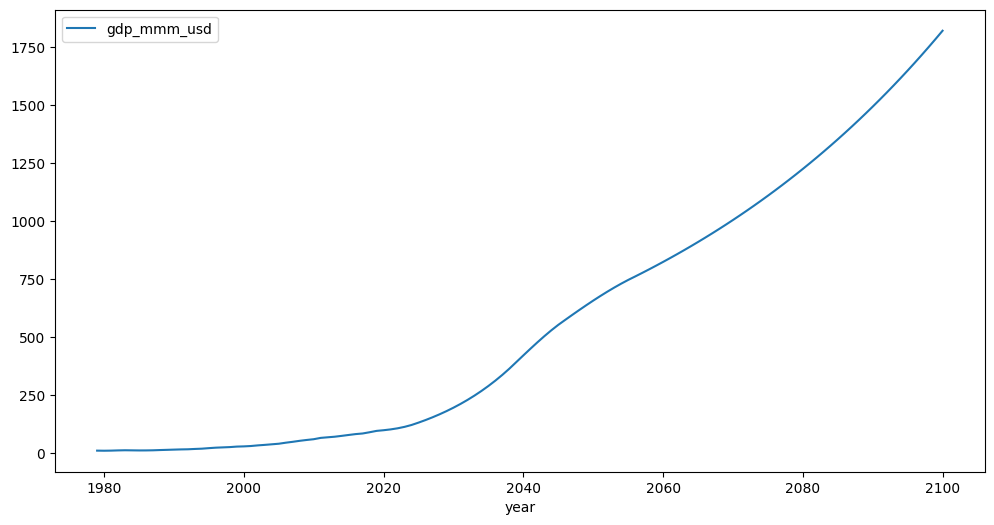

In [114]:
fig, ax = plt.subplots(
    figsize = (12, 6)
)

df_gdp.plot(
    ax = ax,
    x = time_periods.field_year,
)

# Export

In [118]:
df_gdp.to_csv(output_data.joinpath(f"{modvar_gdp.name_fs_safe.upper()}.csv"), index=False)

'GDP'

In [8]:
# Convert growth_rates list to a dictionary mapping year to rate
growth_rate_dict = {}
for start, end, rate in growth_rates:
    for y in range(start, end + 1):
        growth_rate_dict[y] = rate / 100  # Convert percent to decimal

# List to store projections
projection = []
gdp_val = last_gdp

# Project from the year after the last data to 2100
for year in range(last_year + 1, 2101):
    rate = growth_rate_dict.get(year, 0)
    gdp_val *= (1 + rate)
    projection.append({'year': year, 'gdp_mmm_usd': gdp_val})

# Combine observed and projected
gdp_extended = pd.concat([gdp, pd.DataFrame(projection)], ignore_index=True)

In [9]:
# Calculate annual GDP growth rate
gdp_extended['gdp_growth_rate'] = gdp_extended['gdp_mmm_usd'].pct_change() * 100
gdp_extended.tail()

,iso_alpha_3,year,gdp_mmm_usd,gdp_growth_rate
117,NaN,2096,1593.485863,2.0
118,NaN,2097,1625.355580,2.0
119,NaN,2098,1657.862692,2.0
120,NaN,2099,1691.019945,2.0
121,NaN,2100,1724.840344,2.0


<Axes: xlabel='year'>

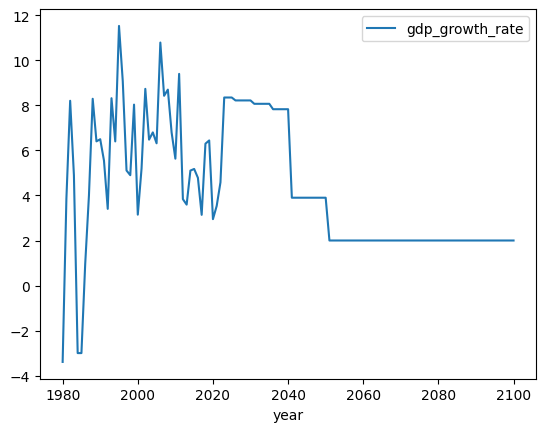

In [10]:
# Plot GDP growth rate
gdp_extended.plot(x = 'year', y='gdp_growth_rate')

<Axes: xlabel='year'>

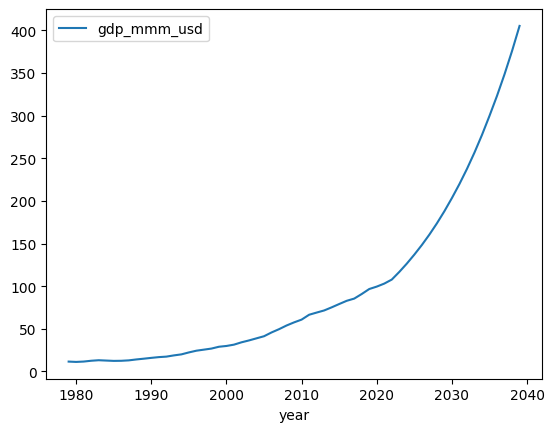

In [11]:
# Plot GDP mmm USD
gdp_extended[gdp_extended['year'] < 2040].plot(x='year', y='gdp_mmm_usd')

<Axes: xlabel='year'>

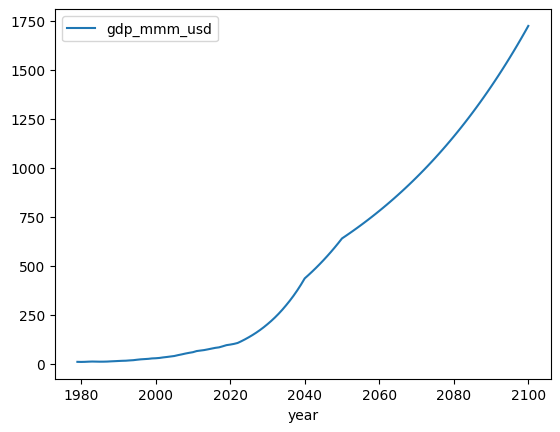

In [12]:
# Plot GDP mmm USD
gdp_extended.plot(x='year', y='gdp_mmm_usd')

## Project Uganda’s GDP to 2100 using a log-linear regression

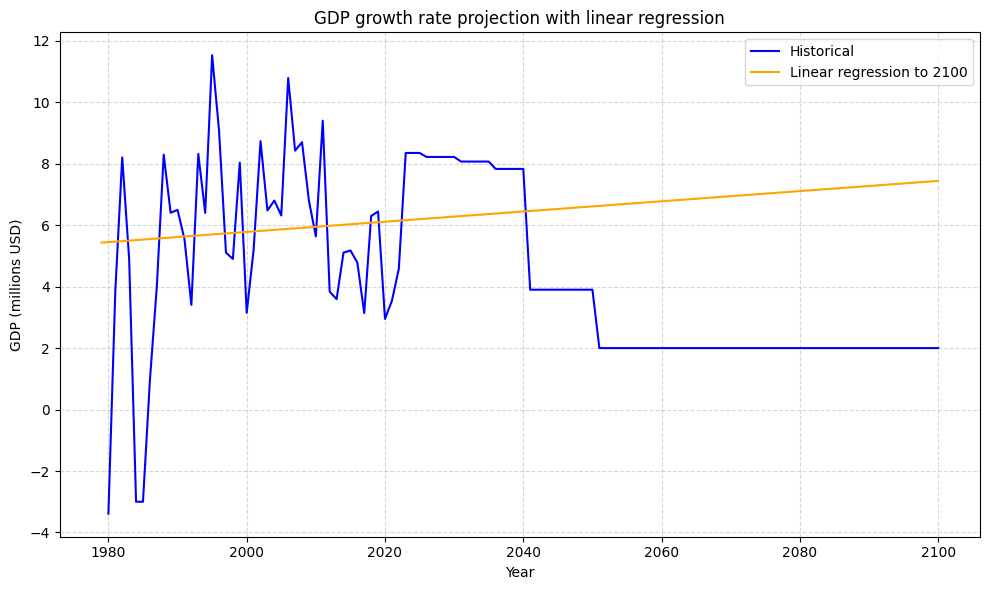

In [13]:

# Filter data from 1981 onwards

X = gdp_extended[(gdp_extended['year'] >= 1981) & (gdp_extended['year'] < 2050)].copy()[['year']]
y = gdp_extended[(gdp_extended['year'] >= 1981) & (gdp_extended['year'] < 2050)].copy()['gdp_growth_rate']

model = LinearRegression()
model.fit(X, y)

future_years = np.arange(gdp_extended['year'].min(), 2101)
future_X = future_years.reshape(-1, 1)
gdp_preds = model.predict(future_X)

gdp_proj_linear = pd.DataFrame({
    'year': future_years,
    'gdp_growth_rate': gdp_preds
})

# Plot
plt.figure(figsize=(10,6))
plt.plot(gdp_extended['year'], gdp_extended['gdp_growth_rate'], label='Historical', color='blue')
plt.plot(gdp_proj_linear['year'], gdp_proj_linear['gdp_growth_rate'], label='Linear regression to 2100', color='orange')
plt.title('GDP growth rate projection with linear regression')
plt.xlabel('Year')
plt.ylabel('GDP (millions USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Prepare the final DataFrame with the required columns
gdp_extended = gdp_extended.drop(columns=['iso_alpha_3', 'gdp_growth_rate'])
gdp_extended.tail()

,year,gdp_mmm_usd
117,2096,1593.485863
118,2097,1625.355580
119,2098,1657.862692
120,2099,1691.019945
121,2100,1724.840344


In [15]:
gdp_extended.to_csv(output_data.joinpath("gdp_mmm_usd.csv"), index=False)